# Micro Fleet of Edge Devices with SageMaker Edge Manager
**SageMaker Studio Kernel**: Data Science

In this exercise you'll create a micro device fleet and use SageMaker Studio as your edge device. You'll learn how to setup a minimalist environment to use SageMaker Edge Manager, Deploy, Load and Test a model using the agent.

## 1) Setup
### 1.1) First you need to prepare and run a Cloudformation template to create the infrastructure required for this experiment
Run the next cell, click on the link it will create and don't forget to ack the capability in the Cloudformation screen

In [ ]:
import boto3
import sagemaker
from IPython import display

s3_client = boto3.client('s3')
sts_client = boto3.client('sts')

session = boto3.session.Session()
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.region_name
bucket_name = sagemaker_session.default_bucket()
account_id = sts_client.get_caller_identity()["Account"]

stack_name='experiments'
fleet_name=f'micro-device-fleet-{stack_name}'
device_name=f'device0-micro-device-fleet-{stack_name}'
policy_name=f'MicroDeviceFleetPolicy-{stack_name}'
iot_policy_name=f'SageMakerEdge-micro-device-fleet-{stack_name}'

template_url=f'https://s3.amazonaws.com/spock.cloud/ml-edge/micro-device-fleet.yml'
template_params={
    'stackName': stack_name,
    'param_BucketName': bucket_name,
    'param_SageMakerRoleArn': role
}
params = "&".join([f"{k}={v}" for k,v in template_params.items()])
cfn_quick_link=f"https://{region}.console.aws.amazon.com/cloudformation/home?region={region}#/stacks/create/review?templateURL={template_url}&{params}"

display.HTML(f'<a href="{cfn_quick_link}"> >>> Click <strong>here</strong> to launch the Cloudformation Stack, but don\'t forget to ack the following capability << </a> ')

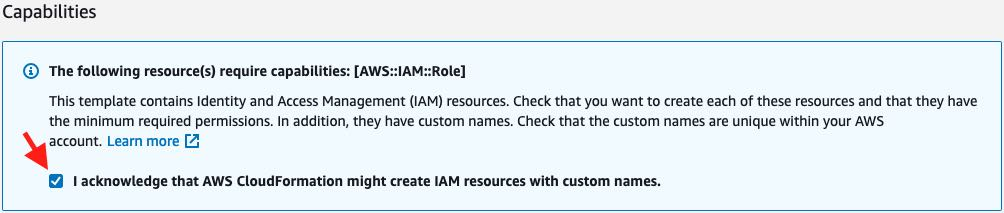</img>

## 1.2) Install some dependencies

In [ ]:
!apt-get -y update && apt-get -y install build-essential procps
!pip install -U numpy sysv_ipc boto3 grpcio-tools grpcio protobuf sagemaker

## 1.3) Download and prepare the SageMaker Edge Agent

### 1.3.1) Download/unpack the agent for X86_64

In [ ]:
import boto3
import sagemaker
import os
import tarfile
import io
import stat

sm_client = boto3.client('sagemaker')

agent_version = '1.20210820.e20fa3a'
agent_pkg_bucket = 'sagemaker-edge-release-store-us-west-2-linux-x64'

if not os.path.isdir('agent'):
    s3_client = boto3.client('s3')

    # Download and install SageMaker Edge Manager
    agent_pkg_key = f'Releases/{agent_version}/{agent_version}.tgz'
    # get the agent package
    with io.BytesIO() as file:
        s3_client.download_fileobj(agent_pkg_bucket, agent_pkg_key, file)
        file.seek(0)
        # Extract the files
        tar = tarfile.open(fileobj=file)
        tar.extractall('agent')
        tar.close()
        # Adjust the permissions
        os.chmod('agent/bin/sagemaker_edge_agent_binary', stat.S_IXUSR|stat.S_IWUSR|stat.S_IXGRP|stat.S_IWGRP)
    
    # by using protoc, we can generate stubs (client api) for connecting to the agent and invoking its API
    if not os.path.isdir('app'): os.mkdir('app')
    !python3 -m grpc_tools.protoc --proto_path=agent/docs/api --python_out=app/ --grpc_python_out=app/ agent/docs/api/agent.proto

### 1.3.2) Create the certificates if needed
These are IoT certificates, used by the agent to communicate with the cloud when needed: to send heartbeats and or capture data

In [ ]:
import urllib.request

cert_root_dir=os.path.join('agent', 'certificates', 'root')
cert_iot_dir=os.path.join('agent', 'certificates', 'iot')
if not os.path.isdir(cert_root_dir): os.makedirs(cert_root_dir)
if not os.path.isdir(cert_iot_dir): os.makedirs(cert_iot_dir)

# assume a different role (created by the CFN you executed at the beginning for IoT ops)
role_arn = f"arn:aws:iam::{account_id}:role/MicroDeviceFleetRole-{stack_name}"
temp_role = boto3.client('sts').assume_role(RoleArn=role_arn, RoleSessionName="MicroDeviceFleetSession2")
credentials = temp_role['Credentials']

iot_client = boto3.client(
    'iot',
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken']
)

if not os.path.isfile(os.path.join(cert_iot_dir, 'device0_key.pem')):
    print('Creating a new certificate')
    cert_meta = iot_client.create_keys_and_certificate(setAsActive=True)
    cert_arn = cert_meta['certificateArn']
    # attach the certificates to the policy and to the thing
    iot_client.attach_policy(policyName=policy_name, target=cert_arn)
    
    with open(os.path.join(cert_iot_dir, 'device0_cert.pem'), 'w') as c: c.write(cert_meta['certificatePem'])
    with open(os.path.join(cert_iot_dir, 'device0_key.pem'),  'w') as c: c.write(cert_meta['keyPair']['PrivateKey'])
    with open(os.path.join(cert_iot_dir, 'device0_pub.pem'),  'w') as c: c.write(cert_meta['keyPair']['PublicKey'])
    
    # get root certs
    urllib.request.urlretrieve('https://www.amazontrust.com/repository/AmazonRootCA1.pem', os.path.join(cert_root_dir, 'AmazonRootCA1.pem'))
    # this certificate validates the edge manage package
    s3_client.download_file(
        Bucket=agent_pkg_bucket, 
        Key=f'Certificates/{region}/{region}.pem', 
        Filename=os.path.join(cert_root_dir, f"{region}.pem")
    )        
    # adjust the permissions of the files
    os.chmod(os.path.join(cert_root_dir, 'AmazonRootCA1.pem'), stat.S_IRUSR|stat.S_IRGRP)
    os.chmod(os.path.join(cert_root_dir, f"{region}.pem"), stat.S_IRUSR|stat.S_IRGRP)

### 1.3.3) Create the Agent config file

In [ ]:
import json
cred_host=iot_client.describe_endpoint(endpointType='iot:CredentialProvider')['endpointAddress']
agent_params = {
    "sagemaker_edge_core_device_name": device_name,
    "sagemaker_edge_core_device_fleet_name": fleet_name,
    "sagemaker_edge_core_capture_data_buffer_size": 30,
    "sagemaker_edge_core_capture_data_batch_size": 10,
    "sagemaker_edge_core_capture_data_push_period_seconds": 4,
    "sagemaker_edge_core_folder_prefix": "micro-device-fleet-data",
    "sagemaker_edge_core_region": region,
    "sagemaker_edge_core_root_certs_path": "./agent/certificates/root",
    "sagemaker_edge_provider_aws_ca_cert_file":"./agent/certificates/root/AmazonRootCA1.pem",
    "sagemaker_edge_provider_aws_cert_file": os.path.join(".", cert_iot_dir, 'device0_cert.pem'),
    "sagemaker_edge_provider_aws_cert_pk_file":os.path.join(".", cert_iot_dir, 'device0_key.pem'),
    "sagemaker_edge_provider_aws_iot_cred_endpoint": f"https://{cred_host}/role-aliases/{iot_policy_name}/credentials",
    "sagemaker_edge_provider_provider": "Aws",
    "sagemaker_edge_provider_provider_path" : os.path.abspath("./agent/lib/libprovider_aws.so"),
    "sagemaker_edge_provider_s3_bucket_name": bucket_name,
    "sagemaker_edge_core_capture_data_destination": "Cloud"
}
conf_dir = os.path.join('agent', 'conf')
conf_file_name='config_edge_device0.json'
if not os.path.isdir(conf_dir): os.makedirs(conf_dir)
with open(os.path.join(conf_dir, conf_file_name), 'w') as conf:
    conf_file = json.dumps(agent_params, indent=4)
    conf.write(conf_file)
    print(conf_file)

## 2) Run the agent in background
The agent is a simple application that will run on your OS. Let's use subprocess to create a background process with the agent

In [ ]:
import subprocess
import time
channel_path='/tmp/agent_dev'
if os.path.exists(channel_path): os.remove(channel_path)
cmd = f'./agent/bin/sagemaker_edge_agent_binary -c agent/conf/{conf_file_name} -a {channel_path}'
print(cmd)
if not os.path.exists('agent/logs'): os.makedirs('agent/logs')
logs = open("agent/logs/agent0.log", "+w")
proc = subprocess.Popen(cmd.split(' '), stdout=logs)
time.sleep(2)
!ps aux --cols 300|grep sagemaker_edge_agent

## 3) Create a deployment package with Resnet18 (pre-compiled in the image classification exercise)

SageMaker Edge Agent expects that the compiled model is signed with a valid certificate. That's why we need to create a SageMaker Edge Manager Packaging.

Let's reuse the model you've created in the previous exercise. If you haven't run it yet, please [click here](./01_ImageClassificationPytorchResnet18.ipynb) and run the whole exercise.

**ATTENTION**: After that, [Click here](https://console.aws.amazon.com/sagemaker/home?#/compilation-jobs) and copy the name of the compilation job created for the Resnet18 Pytorch model.

In [ ]:
import boto3
import sagemaker
import time
import tarfile

compilation_job_name='<<<REPLACE_BY_YOUR_COMPILATION_JOB_NAME_INSTRUCTIONS_ABOVE>>>'

model_name='resnet18'
model_version='1.0'
model_path=os.path.join('agent', 'models', f'{model_name}_224x224_cpu')
sagemaker_session = sagemaker.Session()
sm_client = boto3.client('sagemaker')
output_model_path = f's3://{sagemaker_session.default_bucket()}/{model_name}-pytorch/optimized/model-LINUX_X86_64.tar.gz'

if not os.path.isfile(os.path.join(model_path, 'compiled.so')):
    edge_packaging_job_name=f'micro-fleet-{model_name}-{int(time.time()*1000)}'
    resp = sm_client.create_edge_packaging_job(
        EdgePackagingJobName=edge_packaging_job_name,
        CompilationJobName=compilation_job_name,
        ModelName=model_name,
        ModelVersion=model_version,
        RoleArn=role,
        OutputConfig={
            'S3OutputLocation': f's3://{bucket_name}/{model_name}/{model_version}'
        }
    )
    while True:
        resp = sm_client.describe_edge_packaging_job(EdgePackagingJobName=edge_packaging_job_name)    
        if resp['EdgePackagingJobStatus'] in ['STARTING', 'INPROGRESS']:
            print('Running...')
        else:
            print(resp['EdgePackagingJobStatus'], compilation_job_name)        
            break
        time.sleep(5)
        
    # now unpack the model package into the correct folder
    s3_client = boto3.client('s3')
    with io.BytesIO() as file:
        s3_client.download_fileobj(bucket_name, f'{model_name}/{model_version}/{model_name}-{model_version}.tar.gz', file)
        file.seek(0)
        # Extract the files
        tar = tarfile.open(fileobj=file)
        tar.extractall(model_path)
        tar.close()
        # Adjust the permissions

## 4) Test the model, using SageMaker Edge Agent

In [ ]:
import sys
sys.path.insert(1, 'app')
import numpy as np
import grpc

# Loading the stubs - agent python client
import agent_pb2 as agent
import agent_pb2_grpc as agent_grpc
import edge_agent_utils as edge

In [ ]:
# Connecting to the agent
channel = grpc.insecure_channel(f'unix://{channel_path}' )
client = agent_grpc.AgentStub(channel)

In [ ]:
model_alias='image-classification'

## Loading a model in the agent
edge.load_model(client, model_alias, model_path)

### Validate the model with a dummy payload

In [ ]:
shape=(1,3,224,224)
x = np.random.rand(*shape).astype(np.float32)
y = edge.predict(client, model_alias, x)
print(y.shape)

### Ok, now let's load a real image and get the predictions using the agent

In [ ]:
# quick and dirty parser for the labels
labels = {}
for l in open('labels.txt', 'r').read().splitlines():
    l = l.strip().replace('{', '').replace('}', '')
    l = l[:-1] if l.endswith(',') else l
    cls_id,label = [t.strip() for t in l.split(':')]
    labels[int(cls_id)] = label[1:-1] # remove the single quotes

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
img_size=224
# load the image and make it squared if needed
img = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_BGR2RGB)
h,w,c = img.shape
if w!=h: # pad the image and make it square
    sqr_size = max(h,w)
    sqr_img = np.zeros((sqr_size, sqr_size, c), dtype=np.uint8)
    sqr_img[:h, :w],img = img,sqr_img
# resize the image to the expected size+transform it to pytorch/imagenet format
x = cv2.resize(img, (img_size, img_size)).astype(np.float32) / 255.0
# normalize
x -= [0.485, 0.456, 0.406]
x /= [0.229, 0.224, 0.225]
x = x.transpose(2,0,1) # HWC --> CHW
c,h,w = x.shape
x = x.reshape(1,c,h,w) # CHW --> NCHW

In [ ]:
y = edge.predict(client, model_alias, x)
idx = np.argmax(y)
print(f"Class id: {idx}, Score: {y[0][idx]}, Label: {labels[idx]}")
plt.imshow(img)

### Stop the agent

In [ ]:
# stop the agent
proc.kill()

## Done! :)